## Compare oil type volumes by vessel 

In [1]:
import pandas 
import numpy as np
import matplotlib.pyplot as plt
import yaml
from pathlib import Path

# import functions for querying DOE and monte-carlo dataframes
from monte_carlo_utils import get_montecarlo_oil_byfac, get_montecarlo_oil
from monte_carlo_utils import get_oil_classification
from monte_carlo_utils import get_DOE_quantity_byfac, get_DOE_quantity

In [2]:
#~~~~~  User inputs ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Dept. of Ecology data files
DOE_dir  = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
DOE_2018_xlsx = DOE_dir/'MuellerTrans4-30-20.xlsx'
DOE_2021_xlsx = DOE_dir/'MuellerTrans_5-26-21.xlsx'

data_types    = ['total_gallons', 'fraction_of_total', 'number_of_transfers']
# oil types used in our study
oil_types = [
    'ANS','Bunker-C','Diesel','Gasoline','Jet Fuel', 'Dilbit', 'Other'
]
oil_colors = [
    'orange', 'saddlebrown','darkslateblue',
    'steelblue','slateblue','olive',
    'darkgoldenrod'
]
# create a color dictionary for oil types to us in pie charts
colordict={}
for l,c in zip(oil_types,oil_colors):
    colordict[l]=c

# 10,000 monte carlo spills
#monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaOilSpills_fixbarge_10000.csv'
#monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaSpills_10000_adjustbargecargo.csv'
monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaOilSpills_fixbarge_10000_1.csv'

# Load Oil Attribution file 
oil_attribution_file = '/Users/rmueller/Data/MIDOSS/marine_transport_data/oil_attribution.yaml'

with open(oil_attribution_file) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

# location of output excel spreadsheets
output_directory = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
graphics_directory = Path(
    '/Users/rmueller/Projects/MIDOSS/graphics_figures/monte_carlo'
)

# The precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# unit conversions
gal2m3 = 0.00378541

# facility names

# The following list includes facilities used in Casey's origin/destination 
# analysis with names matching the Dept. of Ecology (DOE) database.  
# For example, the shapefile "Maxum Petroleum - Harbor Island Terminal" is 
# labeled as 'Maxum (Rainer Petroleum)' in the DOE database.  I use the 
# Ecology language here and will need to translate to Shapefile speak

# Terminals that are grouped in voyage joins are removed, e.g.:
# 'Maxum (Rainer Petroleum)' and 'Shell Oil LP Seattle Distribution Terminal' 
# are represented in
#  ==>'Kinder Morgan Liquids Terminal - Harbor Island' 
# 'Nustar Energy Tacoma' => 'Phillips 66 Tacoma Terminal'
facility_names = [ 
    'BP Cherry Point Refinery', 'Shell Puget Sound Refinery', 
    'Tidewater Snake River Terminal', 'SeaPort Sound Terminal', 
    'Tesoro Vancouver Terminal', 'Phillips 66 Ferndale Refinery', 
    'Phillips 66 Tacoma Terminal', 
    'Andeavor Anacortes Refinery (formerly Tesoro)',
    'Tesoro Port Angeles Terminal','U.S. Oil & Refining',
    'Naval Air Station Whidbey Island (NASWI)',
    'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 
    'Kinder Morgan Liquids Terminal - Harbor Island' ,  
    'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 
    'Tidewater Vancouver Terminal','TLP Management Services LLC (TMS)'
]


### Get DOE and monte-carlo attributions (both facility transfers and all transfers)

In [3]:
#--------------------------------------------------------------------------------
# Sum DOE oil transfers to/from facilities by oil and vessel types
#--------------------------------------------------------------------------------
print('Getting DOE volume transfers by Salish Sea facilities')
exports, imports, combined = get_DOE_quantity_byfac(
    DOE_2018_xlsx, facilities='selected'
)

#--------------------------------------------------------------------------------
# Sum all DOE oil transfers by oil and vessel types
#--------------------------------------------------------------------------------
print('Getting all DOE volume transfers for WA')
exports_all, imports_all, combined_all = get_DOE_quantity(DOE_2018_xlsx)

#--------------------------------------------------------------------------------
# Sum monte-carlo tank capacities in spills file by vessel and oil types
# to estimate oil type traffic based only on transfers to/from marine facilities 
#--------------------------------------------------------------------------------
mc_export = {}
mc_import = {}
mc_allUS = {}
for idx,vessel in enumerate(["tanker","atb","barge"]):
    # calculate total cargo_capacity by vessel type and oil type
    print(f'Getting monte-carlo {vessel} exports/imports to/from WA marine terminals')
    mc_export[vessel], mc_import[vessel] = get_montecarlo_oil_byfac(
        vessel, 
        monte_carlo_csv
    )
    # calculate total cargo_capacity by vessel type and oil type
    print(f'Getting monte-carlo {vessel} representation of US oil transport')
    mc_allUS[vessel] = get_montecarlo_oil(
        vessel, 
        monte_carlo_csv
    )

# Add entries for oil types that may not be in monte-carlo file
# so that the DOE and monte-carlo information in the same format
# I intend to eventually put this will go into monte_carlo_utils.py 
# script if using a key-value pair for both information sources 
# will ensure that I don't make an ordering mis-match mistake
for vessel in ["tanker","atb","barge"]: 
    mc_export[vessel] = dict(mc_export[vessel])
    mc_allUS[vessel] = dict(mc_allUS[vessel])
    # Add oil types missing in US traffic 
    # e.g. Dilbit is missing in tanker, ANS is missing in ATBs
    for oil in oil_types: 
        if oil not in mc_export[vessel].keys():
            mc_export[vessel][oil] = 0.0
            mc_allUS[vessel][oil] = 0.0

Getting DOE volume transfers by Salish Sea facilities
Tallying atb quantities
Tallying barge quantities
Tallying tanker quantities
Getting all DOE volume transfers for WA
Tallying atb quantities
Tallying barge quantities
Tallying tanker quantities
Getting monte-carlo tanker exports/imports to/from WA marine terminals
Getting monte-carlo tanker representation of US oil transport
Getting monte-carlo atb exports/imports to/from WA marine terminals
Getting monte-carlo atb representation of US oil transport
Getting monte-carlo barge exports/imports to/from WA marine terminals
Getting monte-carlo barge representation of US oil transport


### Check: Is there dilbit in monte-carlo

In [4]:
mcdf = pandas.read_csv(monte_carlo_csv)
mcdf.groupby(
    'Lagrangian_template'
).cargo_capacity.sum()

Lagrangian_template
Lagrangian_akns.dat      6.297207e+09
Lagrangian_bunker.dat    2.501182e+10
Lagrangian_diesel.dat    3.754784e+10
Lagrangian_dilbit.dat    1.519596e+08
Lagrangian_gas.dat       3.436718e+09
Lagrangian_jet.dat       1.280186e+09
Lagrangian_other.dat     2.511821e+09
Name: cargo_capacity, dtype: float64

In [5]:
### Dilbit isn't showing up in terminal transfer plots (below).  ID source(s)
dilbit = mcdf.loc[
    (mcdf.Lagrangian_template == 'Lagrangian_dilbit.dat'),
    ['vessel_origin','vessel_dest']
]
dilbit.shape

(4, 2)

In [6]:
dilbit

,vessel_origin,vessel_dest
1964,Westridge Marine Terminal,US
2608,Pacific,Westridge Marine Terminal
3265,Westridge Marine Terminal,Pacific
6758,Westridge Marine Terminal,Canada


### Create: Dictionary for percentage values and comparison

In [7]:
percent_oil_df = {}
percentages = {}
for idx,vessel in enumerate(["tanker", "atb", "barge"]):
    percentages = {'DOE': [], 'monte-carlo': [], 'DOE_minus_monte-carlo': []}
    percentages['DOE']  = [
       100*exports[vessel][oil]/sum(exports[vessel].values()) for oil in exports[vessel].keys()
    ]
    percentages['monte-carlo']  = [
       100*mc_export[vessel][oil]/sum(mc_export[vessel].values()) for oil in exports[vessel].keys()
    ]
    percentages['DOE_minus_monte-carlo'] = [
        percentages['DOE'][idx] - percentages['monte-carlo'][idx] for idx in range(len(percentages['DOE']))
    ] 
    percent_oil_df[vessel] = pandas.DataFrame(
        data=percentages,
        index=exports[vessel].keys()
    ).rename_axis(index=f'{vessel} export')

In [8]:
def calc_percent_difference(DOE_dict, MC_dict):
    """
    Inputs: dictionaries created by get_montecarlo_oil_byfac, 
         get_montecarlo_oil, get_DOE_quantity, get_DOE_quantity_byfac
    Outputs: Dictionary organized by vessel type with columns corresponding to 
        oil_type percentages for DOE, monte-carlo csv and difference
    """
    percent_oil_df = {}
    percentages = {}
    for idx,vessel in enumerate(["tanker", "atb", "barge"]):
        percentages = {
            'DOE': [], 
            'monte-carlo': [], 
            'DOE_minus_monte-carlo': []
        }
        percentages['DOE']  = [
           100*DOE_dict[vessel][oil]/sum(DOE_dict[vessel].values()) 
            for oil in DOE_dict[vessel].keys()
        ]
        # note: I'm using the DOE dictionary to loop through oil types 
        # so that the order of the output lists are identical 
        percentages['monte-carlo']  = [
           100*MC_dict[vessel][oil]/\
            sum(MC_dict[vessel].values()) 
            for oil in DOE_dict[vessel].keys()
        ]
        percentages['DOE_minus_monte-carlo'] = [
            percentages['DOE'][idx] - \
            percentages['monte-carlo'][idx] \
            for idx in range(len(percentages['DOE']))
        ] 
        percent_oil_df[vessel] = pandas.DataFrame(
            data=percentages,
            index=exports[vessel].keys()
        ).rename_axis(index=f'{vessel} export')
        
    return percent_oil_df

---
## Plot monte carlo and DOE representation of oil exports by vessel types
---

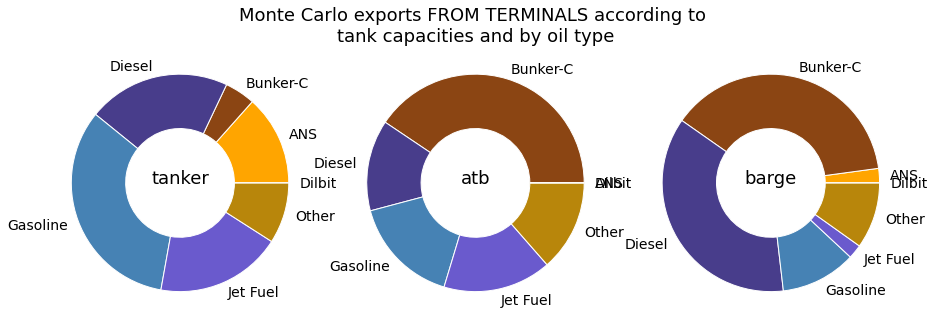

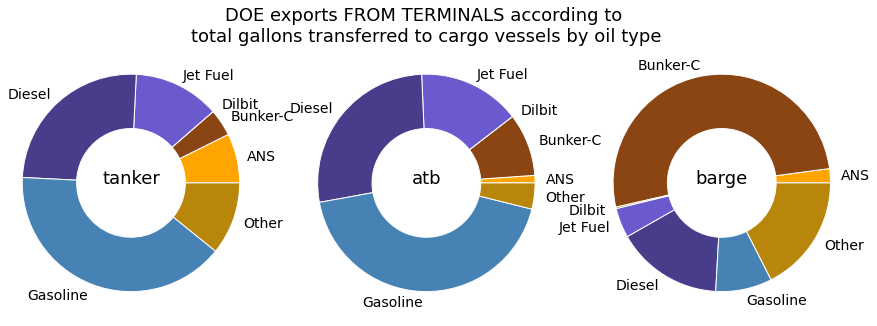

In [9]:
#--------------------------------------------------------------------------------
# Plot monte-carlo representation of oil export 
#--------------------------------------------------------------------------------
# Get cargo exports by vessel type and add up cargo_capacities by oil type
fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge"]):

    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            ('Monte Carlo exports FROM TERMINALS according to \n'
             'tank capacities and by oil type'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        mc_export[vessel].values(), 
        labels = mc_export[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'monte_carlo_oil_exports_v2')
#--------------------------------------------------------------------------------
## Plot department of ecology volume transfers from marine terminals by oil types
#--------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge",]):
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            ('DOE exports FROM TERMINALS according to \n'
             'total gallons transferred to cargo vessels by oil type'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        exports[vessel].values(), 
        # commented out version 
#         labels = [
#             f'{oil}({100*exports["atb"][oil]/sum(exports["atb"].values()):0.1f}%)' for oil in exports['atb'].keys()
#         ],
        labels = exports[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        # commented out version parses label to get oil name for color dictionary
        #pie_wedge.set_facecolor(colordict[pie_wedge.get_label().split('(')[0]])
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'DOE_oil_exports_byterminals.png')

### Print: Percentages relating to differences in exports from marine terminals
(correspongind to above graphic)

In [10]:
percent_test = calc_percent_difference(exports, mc_export)
percent_test

{'tanker':                      DOE  monte-carlo  DOE_minus_monte-carlo
 tanker export                                               
 ANS             7.357602    13.431827              -6.074226
 Bunker-C        4.033961     4.528030              -0.494069
 Dilbit          0.000000     0.000000               0.000000
 Jet Fuel       12.821757    18.760461              -5.938705
 Diesel         24.990810    21.196383               3.794427
 Gasoline       39.992024    33.027237               6.964787
 Other          10.803846     9.056060               1.747785,
 'atb':                   DOE  monte-carlo  DOE_minus_monte-carlo
 atb export                                               
 ANS          1.113387     0.000000               1.113387
 Bunker-C     9.343245    40.582420             -31.239175
 Dilbit       0.000000     0.000000               0.000000
 Jet Fuel    15.238550    16.105545              -0.866995
 Diesel      27.174054    13.557749              13.616305
 Gasoline  

## Take aways:
- We do tanker exports reasonably well. :-) 
- We do jet fuel reasonably well for all vessel
- We tend to get Bunker-C right for tanker and barges
- We show Bunker as the dominant ATB export where DOE shows gasoline (We under attribute gasoline and over-attribute bunker-C in atbs)
- We show less Bunker-C in barge export and more deisel than DOE barge export 

Plausible explanations: 
- Our vessel join method is biased in which terminals it captures. 
- Barge tugs may be attributed as ATB tugs and visa versa (hence, attributed differently in our attribution than in DOE data)     

---
## Plot representations of US oil transport according to our monte carlo and DOE oil transfers 
---

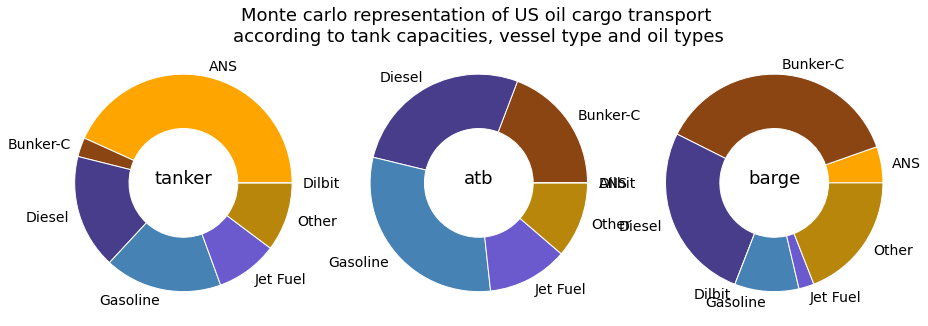

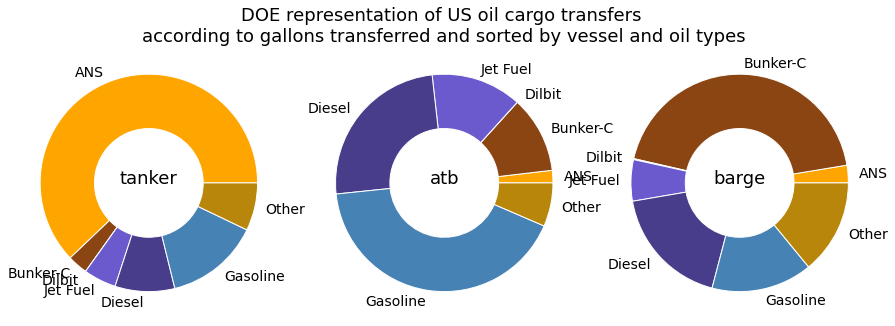

In [11]:
#--------------------------------------------------------------------------------
# Plot monte-carlo representation of US oil transport 
#--------------------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge"]):
   
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            ('Monte carlo representation of US oil cargo transport \n'
            'according to tank capacities, vessel type and oil types'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        mc_allUS[vessel].values(), 
        labels = mc_allUS[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'monte_carlo_USoil')

#--------------------------------------------------------------------------------
## Plot department of ecology volume transfers from marine terminals by oil types
#--------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge",]):
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            ('DOE representation of US oil cargo transfers \n'
             'according to gallons transferred and sorted by '
             'vessel and oil types'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        combined_all[vessel].values(), 
        labels = combined_all[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'DOE_oil.png')

### Print: Percentages relating to US oil cargo transport 
(and differences shown in above graphic)

In [12]:
percent_test = calc_percent_difference(combined_all, mc_allUS)
percent_test

{'tanker':                      DOE  monte-carlo  DOE_minus_monte-carlo
 tanker export                                               
 ANS            62.122816    43.239078              18.883738
 Bunker-C        3.000172     2.854042               0.146129
 Dilbit          0.000000     0.000000               0.000000
 Jet Fuel        4.855479     9.196500              -4.341021
 Diesel          8.872796    17.011298              -8.138502
 Gasoline       14.036811    17.458912              -3.422100
 Other           7.111926    10.240170              -3.128243,
 'atb':                   DOE  monte-carlo  DOE_minus_monte-carlo
 atb export                                               
 ANS          1.854203     0.000000               1.854203
 Bunker-C    11.440769    19.212592              -7.771823
 Dilbit       0.000000     0.000000               0.000000
 Jet Fuel    13.490842    11.959730               1.531111
 Diesel      24.851243    26.998211              -2.146968
 Gasoline  

---
## Plot monte carlo and DOE representation of oil imports by vessel types
---

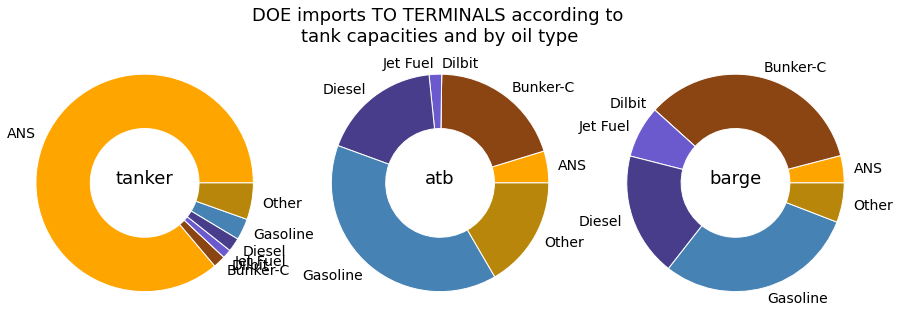

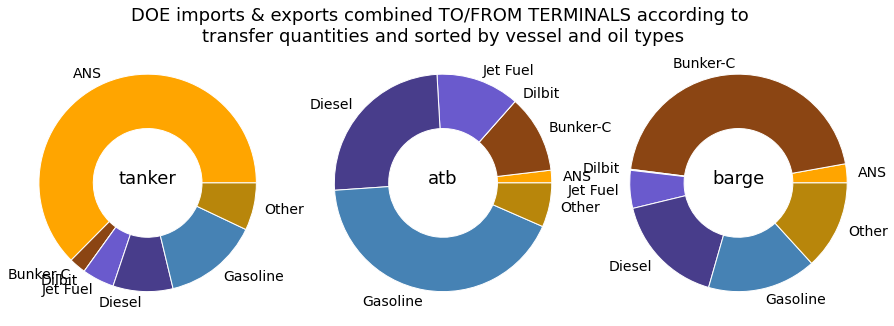

In [13]:
fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge",]):
    # calculate total cargo_capacity by vessel type and oil type
    net_import = imports[vessel].values()
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            ('DOE imports TO TERMINALS according to \n'
             'tank capacities and by oil type'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        net_import, 
        labels = imports[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'DOE_oil_imports_byterminals')

fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge",]):
    # calculate total cargo_capacity by vessel type and oil type
    net_combined = combined[vessel].values()
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
           ('DOE imports & exports combined TO/FROM TERMINALS according to \n'
             'transfer quantities and sorted by vessel and oil types'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        net_combined, 
        labels = combined[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'DOE_oil_combined_byterminals')

### NEXT: 
- Plot up all cargo transfers 
- Plot up all cargo oil in monte carlo (both terminal and non-terminal transfrrs)
- Plot up combined imports and exports to terminals
